<h1><b> Comparing North America's Biggest Cities <b><h1>

---

For my Capstone project, I'll use Foursquare location data from the largest city present in each of the top 3 most populous countries in North America, to see if there are similarities among them.

The cities that are going to be compared are Mexico City in Mexico, New York in the United States and Toronto in Canada.

We have been given the datasets for Toronto and New York in previous labs, additional to those datasets I will use a dataset for Mexico City (found at https://www.correosdemexico.gob.mx/SSLServicios/ConsultaCP/Descarga.aspx) containing Postal Codes that will help us retrieve location data using geocoder.

After cleansing the data we will use a clustering techniques to find similarities and dissimilarities between these three cities.

Obtained insights can help stakeholders decide wether if is feacible to expand a known successful business into another city, trying to reduce risks by knowing if the cities are similar or not.

As the data is inherently related to its location, the results from this experiment can also give an idea of where to locate a physical store in the case this is needed.

First, to start this analysis we need to install and import some useful libraries.

In [1]:
!pip install geocoder # installs geocoder if needed

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import geocoder # import geocoder

import folium # map rendering library

import requests
import json # library to handle JSON files

from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup

     |████████████████████████████████| 98 kB 3.6 MB/s 


We define a function to retrieve the latitude and longitude for each city using geolocator.

In [2]:
def localize(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    longitude = location.longitude
    latitude = location.latitude
    return latitude, longitude

Let's create a dataframe with the cities location.

In [3]:
address_mex = 'Mexico City, MX'
address_new = 'New York, US'
address_tor = 'Toronto, CA'

loc_mex = localize(address_mex) # localize Mexico City
loc_new = localize(address_new) # localize New York
loc_tor = localize(address_tor) # localize Toronto

# We create a dataframe with the location data of each city
df_all = pd.DataFrame( {'Latitude' : [loc_mex[0], loc_new[0], loc_tor[0]],
                       'Longitude' : [loc_mex[1], loc_new[1], loc_tor[1]],
                       'City' : ['Mexico City', 'New York', 'Toronto']})

df_all

,Latitude,Longitude,City
0,19.432630,-99.133178,Mexico City
1,40.712728,-74.006015,New York
2,43.653482,-79.383935,Toronto


Now we will visualize the cities in a map of America.

In [4]:
address_NA = 'United States' # This addres will make a centered map
loc_NA = localize(address_NA)

map_all = folium.Map(location=[loc_NA[0], loc_NA[1]], zoom_start=3) 

# add cities to map
for lat, lng, city in zip(df_all['Latitude'], df_all['Longitude'], df_all['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)  
    
map_all

# <h1> Extracting Mexico City Data <h1>

I'll use an aditional file from the Mexican Postal Service that contains the postal codes for every neighborhood in Mexico City, in order to extract the latitudes and longitudes with geocoder. The information is contained in a HTML file, available at my GitHub repository.

In [5]:
file_ = 'CodigosPostales.html'
df_mex = pd.read_html(file_)

Once opened, we neet to modify some things in the dataframe

In [6]:
df_mex = df_mex[1] # df_mex[0] contains the header so it is discarded
df_mex.columns = df_mex.iloc[0] # column names are stored in the first row of the file
df_mex = df_mex.iloc[1: , :] # Discarding the row that contained the Column names
df_mex = df_mex[df_mex['Tipo de Asentamiento'].str.contains("Colonia")] # Keeping only occurences of 'Colonia', spanish word for Neighborhood
df_mex.drop(['Estado', 'Ciudad', 'Tipo de Asentamiento', 'Clave de Oficina'], axis=1, inplace=True) # droping unused features

The data comes written in Spanish so I rename the colums to make all dataframes consistent.

In [7]:
df_mex.rename({'Código Postal': 'PostalCode', 'Municipio': 'Borough', 
                            'Asentamiento' : 'Neighborhood'}, axis=1, inplace=True) 

Geocoder uses Postal Codes to retreive latitude and longitude for each neighborhood, so we will drop any duplicates.

In [8]:
df_mex.drop_duplicates(subset = 'PostalCode', keep = False, inplace = True) # Droping duplicated PCs

Discarding Boroughs at the periphery of the city to reduce dataframe size.

In [9]:
df_mex = df_mex[df_mex['Borough'].isin(['Venustiano Carranza',
                                        'Álvaro Obregón',
                                        'Miguel Hidalgo',
                                        'Benito Juárez',
                                        'Cuauhtémoc',
                                        'Coyoacán'])]

Using geocoder to extract the latitudes and longitudes of each neighborhood in Mexico City.

In [10]:
latitude=[]
longitude=[]

for code in df_mex['PostalCode']:
    g = geocoder.arcgis('{}, Mexico City, Mexico'.format(code))
    print(code, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Mexico City, Mexico'.format(code))
        print(code, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

# Adding latitudes and longitudes to the dataframe
df_mex['Latitude'] = latitude
df_mex['Longitude'] = longitude

01857 [19.316355000000044, -99.27124463299998]
01859 [19.324003250000032, -99.26842499999998]
01860 [19.321249375000036, -99.26273999999995]
01863 [19.245786900160738, -99.07779514418635]
01870 [19.326028750000035, -99.25670999999994]
01900 [19.318918446000055, -99.20812499999994]
01904 [19.24578848482082, -99.07778669178039]
06000 [19.433076202000052, -99.13844612799994]
06010 [19.433070000000043, -99.13761270899994]
06020 [19.245934766541364, -99.07693727934998]
06030 [19.435245000000066, -99.15379782199994]
06040 [19.24593543622815, -99.07693313599187]
06050 [19.245935771071544, -99.07693106431282]
06060 [19.26473998896067, -99.12037000950443]
06070 [19.245936440758328, -99.0769269209547]
06080 [19.24593677560172, -99.07692484927566]
06090 [19.245937110445116, -99.07692277759661]
06100 [19.408532534000074, -99.17258499999997]
06140 [19.415625000000034, -99.17495405999995]
06170 [19.408900000000074, -99.17999493199994]
06200 [19.44808727800006, -99.13088499999998]
06220 [19.461280000

Postal Code is no longer relevant so it is dropped.

In [11]:
df_mex.drop(['PostalCode'], axis=1, inplace=True)

In [12]:
df_mex.head()

,Borough,Neighborhood,Latitude,Longitude
1,Álvaro Obregón,Lomas de Chamontoya,19.316355,-99.271245
2,Álvaro Obregón,Tlacoyaque,19.324003,-99.268425
3,Álvaro Obregón,Lomas de La Era,19.321249,-99.262740
4,Álvaro Obregón,Lomas del Capulín,19.245787,-99.077795
5,Álvaro Obregón,Lomas de los Cedros,19.326029,-99.256710


The obtained dataframe can be used for the requests to the Foursquare API to retreive venue information.

Visualizing the Neighborhoods in Mexico City.

In [13]:
map_mex = folium.Map(location=[loc_mex[0], loc_mex[1]], zoom_start=10) 

# add markers to map
for lat, lng, borough, neighborhood in zip(df_mex['Latitude'], df_mex['Longitude'], df_mex['Borough'], df_mex['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mex)  
    
map_mex

# <h1> Obtaining New York's Dataset <h1>

In a previous lab we extracted New York location data from a json file stored in the IBM cloud. I will use this data to conform my New York dataframe.


The json file is requested from an URL and then parsed into a pandas dataframe.

In [14]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] # define the dataframe columns

neighborhoods = pd.DataFrame(columns=column_names) # instantiate the dataframe

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
df_new = neighborhoods

In [15]:
df_new.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


This file contains all the information needed for the creation of the New York city dataframe. It contains the same columns as the Mexico City dataframe and can be used to obtain venue information.

Visualizing the Neighborhoods in New York.

In [16]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[loc_new[0], loc_new[1]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# <h1> Extracting Toronto Dataset <h1>

Toronto data is extracted from an article in wikipedia through a request to its URL. Then, using Beautiful Soup, dictionaries with the relevant information are created to later be parsed to dataframes.

In [17]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

table_contents = [] # Firstly create a list
table = soup.find('table') # Finding the table and table data  
for row in table.findAll('td'): # finding content under the tag '<td>'
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else: # Create a dictionary called cell having 3 keys PostalCode, Borough and Neighborhood
        cell['PostalCode'] = row.p.text[:3] # As postal code contains upto 3 characters extract that using tablerow.p.text
        cell['Borough'] = (row.span.text).split('(')[0] # Use split, strip and replace functions for getting Borough and Neighborhood info
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell) # Append to the list

We use pandas to create a dataframe from the extracted dictionaries

In [18]:
df_tor = pd.DataFrame(table_contents)
df_tor['Borough'] = df_tor['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

As in the Mexico City data, we need to extract latitudes and longitudes using geocoder.

In [19]:
latitude=[]
longitude=[]

for code in df_tor['PostalCode']:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
    print(code, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
        print(code, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

df_tor['Latitude'] = latitude
df_tor['Longitude'] = longitude

M3A [43.74997500000006, -79.32759984899997]
M4A [43.730638439000074, -79.31296499999996]
M5A [43.65512000000007, -79.36263979699999]
M6A [43.72328500000003, -79.45099134699996]
M7A [43.66188604900003, -79.39171499999998]
M9A [43.66263166700003, -79.52830499999999]
M1B [43.81185500000004, -79.19671881899995]
M3B [43.74945000000008, -79.36160130099995]
M4B [43.70731500000005, -79.31172543399998]
M5B [43.65749071400006, -79.37849499999999]
M6B [43.70686500000005, -79.44897611699997]
M9B [43.650328570000056, -79.55370999999997]
M1C [43.785615000000064, -79.15870501499995]
M3C [43.72171000000003, -79.34357515299996]
M4C [43.69068500000003, -79.30728784699994]
M5C [43.65190000000007, -79.37573579699995]
M6C [43.692072705000044, -79.43051499999996]
M9C [43.648573449000025, -79.57824999999997]
M1E [43.76574500000004, -79.17469666799997]
M4E [43.67656631800003, -79.29566999999997]
M5E [43.64516306500008, -79.37355999999994]
M6E [43.68787535200005, -79.45025999999996]
M1G [43.77144000000004, -79

We then drop the 'PostalCode' column since it won't be used again.

In [20]:
df_tor.drop(['PostalCode'], axis=1, inplace=True)

In [21]:
df_tor.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.749975,-79.327600
1,North York,Victoria Village,43.730638,-79.312965
2,Downtown Toronto,"Regent Park, Harbourfront",43.655120,-79.362640
3,North York,"Lawrence Manor, Lawrence Heights",43.723285,-79.450991
4,Queen's Park,Ontario Provincial Government,43.661886,-79.391715


The obtained dataframe is consistent with the other cities dataframes. This will let us request venue information from Foursquare for each of the cities.

Let's visualize Toronto's Neighborhoods. 

In [22]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[loc_tor[0], loc_tor[1]], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now that we have the 3 datasets let's check their dimensions.

In [23]:
print('The Mexico City dataframe shape is', df_mex.shape)
print('The New York dataframe shape is', df_new.shape)
print('The Toronto dataframe shape is', df_tor.shape)

The Mexico City dataframe shape is (312, 4)
The New York dataframe shape is (306, 4)
The Toronto dataframe shape is (103, 4)


The larger cities have larger datasets. It is needed to use a similar amount of data for each city in order to avoid bias in the machine learning technique that is going to be used.

# <h1> Extracting Venue Information using Foursquare <h1>

To go further, first we need to define our Foursquare credentials.

In [ ]:
# If running this notebook, remember to include your Foursquare credentials in
# the next lines of code.

CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

The 'getNearbyVenues' function does the requests to Foursquare API for each of the neighborhoods and parses the information to a single dataframe.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## <h2> Clustering through a joined dataset <h2>

For the kMeans experiment I decided to use a dataset that joins all the venue information from the three cities.

In [26]:
df_temp = pd.concat([df_mex, df_new, df_tor])

Using the 'getNearbyVenues' function on the joined dataframe.

In [27]:
df_whole = getNearbyVenues(names = df_temp['Neighborhood'], 
                                 latitudes = df_temp['Latitude'], 
                                 longitudes = df_temp['Longitude']);

Lomas de Chamontoya
Tlacoyaque
Lomas de La Era
Lomas del Capulín
Lomas de los Cedros
Jardines del Pedregal
San Jerónimo Aculco
Centro (Área 1)
Centro (Área 2)
Centro (Área 3)
Tabacalera
Centro (Área 4)
Centro (Área 5)
Centro (Área 6)
Centro (Área 7)
Centro (Área 8)
Centro (Área 9)
Hipódromo
Condesa
Hipódromo Condesa
Morelos
Peralvillo
Valle Gómez
Ex-Hipódromo de Peralvillo
Maza
Felipe Pescador
Guerrero
Buenavista
Santa María la Ribera
Santa María Insurgentes
Atlampa
San Rafael
Cuauhtémoc
Juárez
Roma Norte
Doctores
San Ángel
Los Alpes
Guadalupe Inn
Florida
Campestre
Ex-Hacienda de Guadalupe Chimalistac
Chimalistac
Progreso Tizapan
Ermita Tizapan
Pólvora
La Conchita
Ampliación Acueducto
Reacomodo Pino Suárez
Abraham M. González
Arturo Martínez
Lomas de Santa Fe
Piedad Narvarte
Atenor Salas
Narvarte Poniente
Narvarte Oriente
Roma Sur
Buenos Aires
Obrera
Tránsito
Esperanza
Asturias
Vista Alegre
Paulino Navarro
Algarin
Ampliación Asturias
Nonoalco Tlatelolco
San Simón Tolnáhuac
Molino del R

In [28]:
df_whole.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
23739,"Mimico NW, The Queensway West, South of Bloor,...",43.62517,-79.527032,Solmaz,43.626773,-79.527259,Food & Drink Shop
23740,"Mimico NW, The Queensway West, South of Bloor,...",43.62517,-79.527032,Kingsway Boxing Club,43.627254,-79.526684,Gym
23741,"Mimico NW, The Queensway West, South of Bloor,...",43.62517,-79.527032,Tactical Products Canada,43.626801,-79.529388,Miscellaneous Shop
23742,"Mimico NW, The Queensway West, South of Bloor,...",43.62517,-79.527032,Sleep Country,43.621340,-79.526708,Mattress Store
23743,"Mimico NW, The Queensway West, South of Bloor,...",43.62517,-79.527032,Zam,43.620798,-79.528265,Eastern European Restaurant


In [29]:
df_whole.shape

(23744, 7)

Let's use one-hot encoding to extract information about the venue types existent in the neighborhood, for instance, a 1 represents that the neighborhood contains that Venue Category and 0 indicates that there is none.

In [30]:
# one hot encoding
whole_onehot = pd.get_dummies(df_whole[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
whole_onehot['Neighborhood'] = df_whole['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [whole_onehot.columns[-1]] + list(whole_onehot.columns[:-1])
whole_onehot = whole_onehot[fixed_columns]

whole_onehot

,Zoo,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,...,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Train Station,Travel Lounge,Tree,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Watch Shop,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Yucatecan Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [31]:
whole_grouped = whole_onehot.groupby('Neighborhood').mean().reset_index()
whole_grouped.head()

,Neighborhood,Zoo,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,...,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Train Station,Travel Lounge,Tree,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Watch Shop,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Yucatecan Restaurant
0,10 de Abril,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10 de Mayo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16 de Septiembre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045455,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1° de Mayo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.062500,0.0,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20 de Noviembre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <h2> k-means clustering <h2>

For the clustering technique we do not need the 'Neighborhood' column so we will drop it. Also, I will use feature scaling to avoid posible bias among features.

In [32]:
whole_grouped_clustering = whole_grouped.drop('Neighborhood', 1)

# min-max scaler
whole_grouped_clustering = (whole_grouped_clustering - whole_grouped_clustering.min()) / (whole_grouped_clustering.max() - whole_grouped_clustering.min())

In [33]:
whole_grouped_clustering

,Zoo,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,...,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Train Station,Travel Lounge,Tree,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Watch Shop,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Yucatecan Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.00,0.000000,0.0,0.916667,0.0,0.0,0.0,0.0,0.0,0.138889,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.181818,0.00,0.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.104167,0.0,0.0,0.00,0.0,0.250000,0.00,0.062500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.153846,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04,0.035000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.08,0.0,0.000000,0.05,0.100000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.03,0.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.15,0.0,0.0,0.0,0.0,0.0,0.0
701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34375,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.250000,0.00,0.062500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0

One way of creating a clusterization model with a 'good' number of clusters (that reduces the error but at the same time lets the model be general) is using the so called "elbow method".

The elbow method consist in creating different models with an ascending number of clusters in a given range, and ploting the error of the model, we then select the model where there is a change in the slope of the error function, graphically this looks like an elbow.

This will ensure that the model reduces the error but at the same time has the most generalization capabilitites.

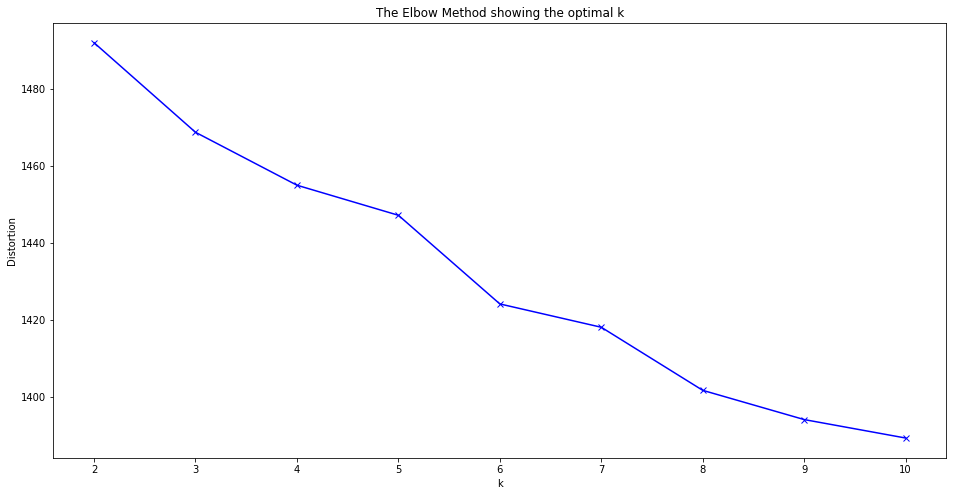

In [34]:
result = []

for k in range(2,11):
  kmeans_ = KMeans(n_clusters=k, random_state=0)
  kmeans_.fit(whole_grouped_clustering)
  result.append(kmeans_.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(2,11), result, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There can be more than one 'joint' or break in slope in the error function, 
or there can be cases where there are no explicit/abrupt breaks in slope, 
making this technique prone to subjectiveness.

In this case, the most abrupt break in slope seems to be around k=6, nonetheless,
adding too much clusters will make the error smaller, but will make generalization of the model harder.

For the sake of simplicity I'll be using 4 clusters. The area around k=4 presents a slight change in slope that can resemble what is looked in the method.

In [35]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(whole_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Grouping dataframe by Neighborhood and adding cluster labels.

In [36]:
df_merge = df_whole.groupby('Neighborhood').mean().reset_index()
df_merge['Cluster Labels'] = kmeans.labels_

df_merge.drop(['Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
df_merge.rename({'Neighborhood Latitude' : 'Latitude',	
                 'Neighborhood Longitude' : 'Longitude'}, axis=1, inplace=True) 

Let's check how many Neighborhoods per cluster label there exist.

In [37]:
df_merge['Cluster Labels'].value_counts()

0    299
2    235
3    126
1     45
Name: Cluster Labels, dtype: int64

From the merged dataframe we need to extract dataframes for each city.

In [38]:
df_mex2 = df_merge[df_merge['Neighborhood'].isin(df_mex['Neighborhood'])]
df_new2 = df_merge[df_merge['Neighborhood'].isin(df_new['Neighborhood'])]
df_tor2 = df_merge[df_merge['Neighborhood'].isin(df_tor['Neighborhood'])]

In [39]:
print('The Mexico City dataframe shape is', df_mex2.shape)
print('The New York dataframe shape is', df_new2.shape)
print('The Toronto dataframe shape is', df_tor2.shape)

The Mexico City dataframe shape is (305, 4)
The New York dataframe shape is (300, 4)
The Toronto dataframe shape is (101, 4)


Neighborhoods with no venue information available are lost, thus the clustered dataframes are a little smaller than the original dataframes.

## <h2> Visualizing clusters in each of the cities <h2>

The next maps show the Neighborhoods colored by their cluster's label, superimposed in the map of each of the cities.

For Mexico City

In [40]:
# create map
map_clusters_mex = folium.Map(location=[df_all.iloc[0][0], df_all.iloc[0][1]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_mex2['Latitude'], df_mex2['Longitude'], df_mex2['Neighborhood'], df_mex2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_mex)
       
map_clusters_mex

New York's map.

In [41]:
# create map
map_clusters_new = folium.Map(location=[df_all.iloc[1][0], df_all.iloc[1][1]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_new2['Latitude'], df_new2['Longitude'], df_new2['Neighborhood'], df_new2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_new)
       
map_clusters_new

And Toronto.

In [42]:
# create map
map_clusters_tor = folium.Map(location=[df_all.iloc[2][0], df_all.iloc[2][1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_tor2['Latitude'], df_tor2['Longitude'], df_tor2['Neighborhood'], df_tor2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_tor)
       
map_clusters_tor

Visually we can start to draw some conclusions, New York and Toronto seem to posses more similarity and Mexico City seems to be completely different.

Let's check the share of clusters for each city, as a function of the total number of clusters. That is the percentage of presence of each cluster by city.

In [43]:
mex_pc = df_mex2['Cluster Labels'].value_counts() * 100 / df_mex2['Cluster Labels'].shape[0]
new_pc = df_new2['Cluster Labels'].value_counts() * 100 / df_new2['Cluster Labels'].shape[0]
tor_pc = df_tor2['Cluster Labels'].value_counts() * 100 / df_tor2['Cluster Labels'].shape[0]

In [44]:
clustOccurence = pd.DataFrame(data={'Mexico City': mex_pc, 
                        'New York' : new_pc, 
                        'Toronto' : tor_pc})

In [45]:
clustOccurence

,Mexico City,New York,Toronto
0,7.213115,69.666667,68.316832
1,0.655738,12.333333,5.940594
2,76.065574,0.333333,1.980198
3,16.065574,17.666667,23.762376


## <h2> Analizing Neighborhoods with features closest to cluster centers <h2>

Until now, one setback of this method is that we do not know what there is in each of the clusters or why the method is grouping neighborhoods in that way.

Cluster don't provide this information for themselves, it needs to be extracted through context. In order to shed some light on the content of each cluster I decided to analize the most common venues in the Neigboorhoods whose features are closest to its assigned cluster center. 

This metric can be related to how "good" is the fit of a certain Neighborhood to its assigned cluster.

First we define a function that extracts the desired number of top venues. I'll be using 10

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then we create a dataframe and add information using the newly defined function.

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_merge['Neighborhood']

for ind in np.arange(whole_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(whole_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10 de Abril,Restaurant,Gym / Fitness Center,Mexican Restaurant,Deli / Bodega,Coffee Shop,Yucatecan Restaurant,Event Space,Fabric Shop,Eye Doctor,Exhibit
1,10 de Mayo,Restaurant,Gym,Mexican Restaurant,Taco Place,History Museum,Park,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,BBQ Joint
2,16 de Septiembre,Mexican Restaurant,Taco Place,Pharmacy,Seafood Restaurant,Coffee Shop,Bakery,Restaurant,Bar,Miscellaneous Shop,Outdoor Sculpture
3,1° de Mayo,Taco Place,Mexican Restaurant,Seafood Restaurant,Bakery,Soup Place,Park,Bar,BBQ Joint,Gymnastics Gym,Coffee Shop
4,20 de Noviembre,Taco Place,Burger Joint,Seafood Restaurant,Mexican Restaurant,Ice Cream Shop,Department Store,Bakery,Soccer Field,Café,Paper / Office Supplies Store


Joining dataframes to include latitude, longitude and cluster label.

In [48]:
df_merge = df_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')
df_merge.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10 de Abril,19.448465,-99.208277,2,Restaurant,Gym / Fitness Center,Mexican Restaurant,Deli / Bodega,Coffee Shop,Yucatecan Restaurant,Event Space,Fabric Shop,Eye Doctor,Exhibit
1,10 de Mayo,19.433545,-99.118168,2,Restaurant,Gym,Mexican Restaurant,Taco Place,History Museum,Park,Seafood Restaurant,Gym / Fitness Center,Coffee Shop,BBQ Joint
2,16 de Septiembre,19.402945,-99.204970,2,Mexican Restaurant,Taco Place,Pharmacy,Seafood Restaurant,Coffee Shop,Bakery,Restaurant,Bar,Miscellaneous Shop,Outdoor Sculpture
3,1° de Mayo,19.445340,-99.101313,2,Taco Place,Mexican Restaurant,Seafood Restaurant,Bakery,Soup Place,Park,Bar,BBQ Joint,Gymnastics Gym,Coffee Shop
4,20 de Noviembre,19.445465,-99.110225,2,Taco Place,Burger Joint,Seafood Restaurant,Mexican Restaurant,Ice Cream Shop,Department Store,Bakery,Soccer Field,Café,Paper / Office Supplies Store


Using the function 'pairwise_distance' from sklearn we can obtain the euclidean "distance" from each of the features to its assigned cluster's center.
Then the indices for the desired number of neighborhoods are extracted and used to select the closest features to each of the cluster centers. I will use the 10 closest neighborhoods.

In [49]:
neigh_num = 10

whole_grouped_clustering['Cluster Labels'] = kmeans.labels_

dfdf = []

# 'neigh_num' has to be always smaller than the minimum number of samples 
# sharing a cluster label, otherwise an error code will emerge

for i in range(kclusters): # cicle through labels
  print(i)
  clustemp = whole_grouped_clustering[whole_grouped_clustering['Cluster Labels'] == i] # cicle through labels
  cluster = clustemp.drop(['Cluster Labels'], axis=1) # drop column to ensure consistent dimensions in the next step
  distances = pairwise_distances(kmeans.cluster_centers_[i].reshape([1, np.shape(kmeans.cluster_centers_)[1]]), cluster, metric='euclidean') # distance center to feature
  distances = np.array(distances, dtype = object)
  ind = [np.argpartition(j, neigh_num)[:neigh_num] for j in distances] # contains the indexes of the closest features
  closest = [df_merge[df_merge['Cluster Labels'] == i].iloc[indexes,:] for indexes in ind] # localizes by index and stores in 'closest'
  dfdf.append(closest)

0
1
2
3


In [50]:
top_clus0 = pd.DataFrame(dfdf[0][0])
top_clus1 = pd.DataFrame(dfdf[1][0])
top_clus2 = pd.DataFrame(dfdf[2][0])
top_clus3 = pd.DataFrame(dfdf[3][0])

In [51]:
top_clus0

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
462,Norwood,40.877224,-73.879391,0,Pizza Place,Park,Pharmacy,Deli / Bodega,Bank,Chinese Restaurant,Mexican Restaurant,Pet Store,Athletics & Sports,Coffee Shop
476,Ozone Park,40.680708,-73.843203,0,Pharmacy,Furniture / Home Store,Pizza Place,Bank,Gym,Diner,Bowling Alley,Shop & Service,Athletics & Sports,Latin American Restaurant
617,Sunnyside,40.724886,-73.947341,0,Pizza Place,Bakery,Coffee Shop,Chinese Restaurant,Italian Restaurant,Deli / Bodega,Discount Store,Grocery Store,Spa,Fast Food Restaurant
158,College Point,40.784903,-73.843045,0,Deli / Bodega,Donut Shop,Latin American Restaurant,Supermarket,Pizza Place,Asian Restaurant,Taco Place,Park,Bakery,Bank
154,Clinton Hill,40.693229,-73.967843,0,Pizza Place,Italian Restaurant,Grocery Store,Wine Shop,Thai Restaurant,Japanese Restaurant,Diner,Arts & Crafts Store,Mexican Restaurant,Yoga Studio
405,Maspeth,40.725427,-73.896217,0,Pizza Place,Deli / Bodega,Diner,Bank,Chinese Restaurant,Grocery Store,Discount Store,Mobile Phone Shop,Taco Place,Lounge
267,Fort Hamilton,40.614768,-74.031979,0,Chinese Restaurant,Italian Restaurant,Deli / Bodega,Convenience Store,Bank,Cocktail Bar,Gym / Fitness Center,Japanese Restaurant,Pharmacy,Sandwich Place
691,Woodbine Heights,43.690685,-79.307288,0,Grocery Store,Pizza Place,Bus Line,Fast Food Restaurant,Pet Store,Pharmacy,Coffee Shop,Metro Station,Café,Gas Station
601,South Ozone Park,40.668550,-73.809865,0,Park,Deli / Bodega,Bar,Food Truck,Hotel,Donut Shop,Sandwich Place,Fast Food Restaurant,Grocery Store,Food
698,York Mills West,43.747850,-79.400329,0,Convenience Store,Coffee Shop,Speakeasy,Park,Factory,Fabric Shop,Eye Doctor,Exhibit,Event Space,Event Service


In [52]:
top_clus1

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
303,High Bridge,40.836623,-73.926102,1,Chinese Restaurant,Pizza Place,Pharmacy,Seafood Restaurant,Spanish Restaurant,Gym,Market,Grocery Store,Park,Donut Shop
76,Bedford Park,40.870185,-73.885512,1,Chinese Restaurant,Diner,Pizza Place,Mexican Restaurant,Deli / Bodega,Food Truck,Spanish Restaurant,Sandwich Place,Pub,Pharmacy
419,Mill Basin,40.615974,-73.915154,1,Chinese Restaurant,Pizza Place,Liquor Store,Bagel Shop,Sushi Restaurant,Japanese Restaurant,Bank,Ice Cream Shop,Peruvian Restaurant,Sandwich Place
103,Brownsville,40.663950,-73.910235,1,Moving Target,Fried Chicken Joint,Chinese Restaurant,Convenience Store,Playground,Burger Joint,Spanish Restaurant,Caribbean Restaurant,Park,Performing Arts Venue
598,Soundview,40.821012,-73.865746,1,Chinese Restaurant,Pharmacy,Breakfast Spot,Bus Stop,Basketball Court,Latin American Restaurant,Pizza Place,Video Store,Discount Store,Playground
492,Pelham Gardens,40.862966,-73.841612,1,Pharmacy,Bus Station,Chinese Restaurant,Deli / Bodega,Sandwich Place,Pizza Place,Donut Shop,Playground,Boat or Ferry,American Restaurant
403,Marine Park,40.609748,-73.931344,1,Gym,Basketball Court,Athletics & Sports,Coffee Shop,Pizza Place,Deli / Bodega,Baseball Field,Chinese Restaurant,English Restaurant,Entertainment Service
468,Ocean Hill,40.678403,-73.913068,1,Deli / Bodega,Chinese Restaurant,Bakery,Grocery Store,Southern / Soul Food Restaurant,Playground,Fried Chicken Joint,Bus Stop,Donut Shop,Salad Place
148,Claremont Village,40.831428,-73.901199,1,Grocery Store,Bus Station,Bakery,Chinese Restaurant,Discount Store,Liquor Store,Medical Center,Caribbean Restaurant,Gift Shop,Pizza Place
269,Fresh Meadows,40.734394,-73.782713,1,Bus Station,Chinese Restaurant,Pharmacy,Cosmetics Shop,Pizza Place,Vegetarian / Vegan Restaurant,Playground,Home Service,Grocery Store,Food Truck


In [53]:
top_clus2

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Argentina Antigua,19.455995,-99.204950,2,Taco Place,Mexican Restaurant,Farmers Market,Convenience Store,Bakery,Grocery Store,Market,Park,Pharmacy,Pizza Place
428,Moderna,19.395192,-99.134565,2,Mexican Restaurant,Taco Place,Sushi Restaurant,Gym,Bar,Fried Chicken Joint,Restaurant,Grocery Store,Park,Bakery
49,Arenal 2a Sección,19.424197,-99.056417,2,Gym,Mexican Restaurant,Park,Taco Place,Department Store,Bakery,Market,Seafood Restaurant,Bar,Pizza Place
580,Santa Cecilia,19.308823,-99.113905,2,Mexican Restaurant,Taco Place,Food Truck,Sushi Restaurant,Convenience Store,Restaurant,Park,Drugstore,Sandwich Place,Coffee Shop
665,Villa de Cortes,19.387540,-99.136080,2,Mexican Restaurant,Taco Place,Burger Joint,Café,Park,Convenience Store,Coffee Shop,Ice Cream Shop,Dog Run,Restaurant
429,Molino de Rosas,19.373175,-99.197925,2,Mexican Restaurant,Taco Place,Café,Farmers Market,Ice Cream Shop,Burger Joint,Pizza Place,Park,Market,Grocery Store
332,Iztaccihuatl,19.390125,-99.135591,2,Mexican Restaurant,Taco Place,Café,Burger Joint,Park,Ice Cream Shop,Coffee Shop,Convenience Store,Fast Food Restaurant,Sushi Restaurant
497,Periodista,19.407251,-99.173296,2,Mexican Restaurant,Taco Place,Food Truck,Restaurant,Gym / Fitness Center,Burger Joint,Convenience Store,Sandwich Place,Breakfast Spot,BBQ Joint
23,Alfonso XIII,19.376210,-99.195429,2,Taco Place,Mexican Restaurant,Seafood Restaurant,Café,Farmers Market,Ice Cream Shop,Bakery,Residential Building (Apartment / Condo),Pizza Place,Donut Shop
50,Arenal 3a Sección,19.428570,-99.056359,2,Park,Mexican Restaurant,Ice Cream Shop,Gym,Market,Flea Market,Sports Club,Athletics & Sports,Seafood Restaurant,Pool


In [54]:
top_clus3

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
602,South Side,40.710861,-73.958001,3,Bar,Pizza Place,Coffee Shop,Wine Bar,Yoga Studio,Chinese Restaurant,American Restaurant,Burger Joint,Grocery Store,Cocktail Bar
73,Bayside,40.766041,-73.774274,3,Bar,Pizza Place,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,Chinese Restaurant,Spa,Pharmacy,Pub,Mediterranean Restaurant
389,Los Girasoles,19.306345,-99.124483,3,Cosmetics Shop,Ice Cream Shop,Sporting Goods Shop,Clothing Store,Coffee Shop,Mexican Restaurant,Park,Gym,Athletics & Sports,Restaurant
91,Boerum Hill,40.685683,-73.983748,3,Coffee Shop,Bar,Dance Studio,French Restaurant,Furniture / Home Store,Arts & Crafts Store,Sandwich Place,Bank,Bakery,Grocery Store
345,Juárez,19.427140,-99.159823,3,Coffee Shop,Italian Restaurant,Bakery,Pizza Place,Ice Cream Shop,Bed & Breakfast,Restaurant,Cosmetics Shop,Mexican Restaurant,Speakeasy
660,Villa Coyoacán,19.347995,-99.171527,3,Coffee Shop,Mexican Restaurant,Bakery,Restaurant,Café,Arts & Crafts Store,Pizza Place,Ice Cream Shop,Theater,Cosmetics Shop
109,"CN Tower, King and Spadina, Railway Lands, Har...",43.640815,-79.398184,3,Italian Restaurant,Coffee Shop,Café,Intersection,French Restaurant,Gym / Fitness Center,Bar,Sandwich Place,Park,Bakery
459,North Side,40.714823,-73.958809,3,Coffee Shop,Pizza Place,Bar,Bakery,Wine Bar,Jewelry Store,Burger Joint,Yoga Studio,American Restaurant,Vegetarian / Vegan Restaurant
479,Park Slope,40.672321,-73.977050,3,Coffee Shop,Italian Restaurant,Pizza Place,Bagel Shop,Burger Joint,Bakery,Gourmet Shop,Spa,Bookstore,Pet Store
120,Carnegie Hill,40.782683,-73.953256,3,Coffee Shop,Café,Wine Shop,French Restaurant,Bookstore,Gym,Pizza Place,Cosmetics Shop,Bar,Gym / Fitness Center


* Clusters 0 groups neighborhoods with diverse food oferings and a diversity of businesses. This cluster seems to group residential zones.

* Cluster 1 has mainly asian food oferings and some other restaurants as well as a variety of shops and markets. This cluster may group commercial zones.

* Cluster 2 groups places where there is mainly Mexican food oferings and some bussinesses. This cluster seems to group mexican-like neighborhoods.

* Cluster 3 has high presence of coffee shops, bars and diverse fast-food like food oferings, as well as some stores. This cluster seems to group leisure districts.

To help us conclude, let's remember cluster ocurrence by city.

In [55]:
clustOccurence

,Mexico City,New York,Toronto
0,7.213115,69.666667,68.316832
1,0.655738,12.333333,5.940594
2,76.065574,0.333333,1.980198
3,16.065574,17.666667,23.762376


# <h1> Conclusion <h1>

Cluster 0 seems to group residenial zones in the northern cities.

Judging by the food offerings present in cluster 1, this cluster might represent a much more diverse/multicultural community.

Cluster 2 represents mainly neighborhoods in Mexico City as it contains many Mexican cuisine venues. This might be why there is a small presence of this cluster in the northern cities.

Cluster 3 is a cluster that we can see in all of the cities, all of them seem to have places to spend some leisure time. This might be the point where we can find most similarity among the tree analized cities

Overall, New York and Toronto present more similarities, a expected result since they are no more than some kilometers apart, contrary to the distance of any of these cities and Mexico City.

The obtained results contain helpful information about how the cities are conformend and offer an easy form of comparing them.

The data and the methods used offer not only numeric advantages but also the capability to interpret this data physically, conforming a visual aid on where can we find different offerings.

The elbow method gives an easy form of calculating the number of clusters to be used, nonetheless sometimes it is hard to select the number of clusters since the error function can present more than one inflection point or none.